In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

css = """
<style>
    .jp-Notebook .jp-Cell {
        margin-bottom: 16px !important;
    }
</style>
"""

display(HTML(css))

# Introduction

Will study online retail store dataset. First let's understand the data itself. Do note that, i didn't find those information as it is and most of them i learned as i fuck around and found out about it. Here i tried to compile everything in logical order but this was not the first attempt in understanding the data.

## EDA

In [118]:
df = pd.read_excel("Online Retail.xlsx")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Looking at above data, I can see that i can analyze product, country and customer data. Rest of them are supplementary of it. Also looking at StockCode and Description, i feel there should be one to one correspondence as both represent single product under the hood.

Let's look at what kind of transaction we have in our dataset

#### Quantity vs UnitPrice

In [11]:
df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


Looking at above numbers, both quantity and unit price go below zero and there are extreme number in both sides. Now with this there are 9 segments of transactions. Made with Quantity > 0 or = 0 or < 0 matched with UnitPrice > 0 or = 0 or < 0.

Let's look at these one by one.

In [17]:
# there are no entries in this segment
# so quantity has to be something for to be recorded in database

df[(df["Quantity"] == 0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [42]:
# from looks of it, these are inventory management and since UnitPrice == 0, it won't affect our
# revenue calculations. The reason i was able to say inventory management is because looking
# at descriptions, there are entries like damaged, re-adjustment, faulty, etc. Went to chatgpt
# with those all descriptions and confirmed these are non sales transactions

df[(df["UnitPrice"] == 0)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom


In [25]:
# these are real sales which we are going to analyze later

df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [27]:
# debt adjustment of business

df[(df["Quantity"] > 0) & (df["UnitPrice"] < 0)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [33]:
# looking at quantity being negative and unitprice > 0. It seems like returned or cancelled section
# of dataset. Also looking through internet i found out that invoice number starting with 'C' are credit
# note for business to indicate like returns or cancellation. Here i can see discount field.
# Let's see if all the invoice number in this section starts with 'C'

creditnote_section = df[(df["Quantity"] < 0) & (df["UnitPrice"] > 0)]
creditnote_section.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [36]:
# so yeah all the invoice number starts with 'C'

creditnote_section["InvoiceNo"].str.startswith('C').unique()

array([ True])

In [38]:
# there are no entries here, and it makes sense as according to my information there are no
# business transactions with both quantity and unit price being -ve.

df[(df["Quantity"] < 0) & (df["UnitPrice"] < 0)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


#### Business dealing with wholesellers

Looking above, i can easily see that there are wholeseller with retail customers. Looking at distribution of it

In [55]:
np.percentile(df[df["Quantity"] > 0]["Quantity"], 70)  # so 70% of data is of retail and rest of them are wholeseller

np.float64(8.0)

In [64]:
(df["Quantity"] < 0).value_counts()

Quantity
False    531285
True      10624
Name: count, dtype: int64

In [65]:
# let's look at number perspective
# yeah threshold == 8 seems contrived but who knows maybe you have bought 8 product even if
# you are retail customer
# don't worry about -ve quantity inclusion in first because as seen above they are about 10K
# which is very small compared to 380K

print(f"About these are retail customer {df[df['Quantity'] <= 8].shape[0]}")
print(f"About these are wholesellers {df[df['Quantity'] > 8].shape[0]}")

About these are retail customer 384953
About these are wholesellers 156956


#### StockCode with alphabets only

In [45]:
# i was searching through Credit note transactions and there i saw some stockcode which
# only has alphabets as stockcode value. There are three types of Stockcode here, one is
# stockcode with only numbers, second one is number + alphabet and lastly only alphabet
# The reason i am interested in alphabets stockcode is because eyeballing some of the transactions
# these seems like internal business stuff and i don't want to include them in my analysis
# for revenue, etc

stockcodes = df["StockCode"].apply(str)
alphacode = df[~stockcodes.str.contains(r"\d", na=False)]
alphacode.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583.0,France
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.00,12791.0,Netherlands
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.00,12662.0,Germany
1814,536544,DOT,DOTCOM POSTAGE,1,2010-12-01 14:32:00,569.77,NaN,United Kingdom


In [48]:
# looking below without examning further will feel like we have to include those entries
# while doing revenue and other analysis but later looking at those extreme values these
# are small in number and internal business stuff won't really matter for trends and stuff

alphacode[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,2796.000000,2796.000000
mean,3.581545,260.852240
std,67.374006,1321.062127
min,-1350.000000,-11062.060000
25%,1.000000,16.722500
50%,1.000000,18.000000
75%,2.000000,161.900000
max,1600.000000,38970.000000


In [50]:
# Later on i looked at each and saw that they really don't matter in my analysis
# yeah 'BOYS PARTY BAG' and it's equivalent will feel like they are real products
# being sold but since they are low in number and it is negligible compared to rest of
# the products

alphacode["Description"].unique()

array(['POSTAGE', 'Discount', 'DOTCOM POSTAGE', 'Manual', 'Bank Charges',
       'SAMPLES', 'AMAZON FEE', nan, 'BOYS PARTY BAG', 'GIRLS PARTY BAG',
       'PADS TO MATCH ALL CUSHIONS', 'Adjust bad debt', 'CRUK Commission'],
      dtype=object)

#### StockCode as representation of product

First look at description having many stockcodes

In [80]:
# what about description having many stockcode

# removing unitprice == 0 because these are according to me inventory management
# and looking at those descriptions they include such as "damage", "clean"
# so it makes sense these corresponds to many stockcodes

stockcodes = df[df["UnitPrice"] != 0].groupby("Description").agg(
    List=("StockCode", lambda x: list(set(x))),
    TotalNo=("StockCode", lambda x: len(list(set(x))))
).reset_index()
unique_nums = np.sort(stockcodes["TotalNo"].unique())
unique_nums

array([1, 2, 6])

In [84]:
# eyeballing these entries feel like they are same but just one is capital and other is lower

double_sc = stockcodes[stockcodes["TotalNo"] == 2]
double_sc.head()

,Description,List,TotalNo
46,3 GARDENIA MORRIS BOXED CANDLES,"[85034a, 85034A]",2
61,3 WHITE CHOC MORRIS BOXED CANDLES,"[85034B, 85034b]",2
72,3D DOG PICTURE PLAYING CARDS,"[84558A, 84558a]",2
74,3D SHEET OF CAT STICKERS,"[84559B, 84559b]",2
75,3D SHEET OF DOG STICKERS,"[84559a, 84559A]",2


In [94]:
# let's confirm this hypothesis for all entries

check = double_sc["List"].apply(lambda x: str(x[0]).upper() == str(x[1]).upper())
check.unique()

array([ True, False])

In [98]:
# so i have to replace the second on with first one in original dataset
# and lastly i have to make each stockcode as string and use upper method

double_sc[check == False].head()

,Description,List,TotalNo
856,COLOURING PENCILS BROWN TUBE,"[10133, 10135]",2
858,COLUMBIAN CANDLE RECTANGLE,"[72131, 72133]",2
859,COLUMBIAN CANDLE ROUND,"[72128, 72130]",2
1124,EAU DE NILE JEWELLED PHOTOFRAME,"[85024B, 85023B]",2
1371,FRENCH FLORAL CUSHION COVER,"[20840, 20837]",2


In [129]:
# similarly adding this to previous stockcode dict

stockcodes[stockcodes["TotalNo"] == 6]

,Description,List,TotalNo
2083,"METAL SIGN,CUPCAKE SINGLE HOOK","[82613B, 82613A, 82613b, 82613C, 82613c, 82613a]",6


In [134]:
stockcode_dict = {row["Description"]: row["List"][0] for _, row in double_sc[check == False].iterrows()}
stockcode_dict[stockcodes[stockcodes["TotalNo"] == 6]["Description"].item()] = stockcodes[stockcodes["TotalNo"] == 6]["List"].item()[0]

def change_sc(row):
    if row["Description"] in stockcode_dict:
        return stockcode_dict[row["Description"]]
    return row["StockCode"]


final_df = df.copy()
final_df["StockCode"] = final_df.apply(change_sc, axis=1)
final_df["StockCode"] = final_df["StockCode"].astype(str).str.upper()

Now looking at stockcode having many descriptions

In [139]:
descriptions = final_df[final_df["UnitPrice"] != 0].groupby("StockCode").agg(
    List=("Description", lambda x: list(set(x))),  # or "unique"
    TotalNo=("Description", lambda x: len(list(set(x))))  # or "nunique"
).reset_index()

descriptions["TotalNo"].unique()

array([1, 2, 3, 4])

In [146]:
# let's look at each records manually
# and yes all the descriptions point to same product
# thus finally we can use stockcode as representation of product

# for _, row in descriptions[descriptions["TotalNo"] > 1].iterrows():
#     print(row["List"])

#### Return vs Cancel orders

In [155]:
# future roop here, so as i was studying credit note transactions. There i saw these two
# transactions at last. Here the customer has placed a very very big order and then cancelled
# within few minutes. These types really distort the results. There are many such like on in
# January. So later while analyzing and finding trends, also take credit note transactions
# into account so that they will cancel out each other and will show correct revenue.
# Yeah i can remove those transactions but i am not confident where should i place
# threshold. Such that above threshold are returns and below are cancelled

final_df[final_df["CustomerID"] == 16446]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2011-05-18 09:52:00,1.65,16446.0,United Kingdom
194355,553573,22982,PANTRY PASTRY BRUSH,1,2011-05-18 09:52:00,1.25,16446.0,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom


#### Time Period of Data

In [153]:
# lastly let's understand the time period when the data is collected
# from looks of it, we have one year worth of data

dates = final_df["InvoiceDate"]
print(dates.head())
print("\n")

# checking if date is sorted or not
print("Starting date: ", dates.iloc[0])
print("Is Monotonic Increasing: ", dates.is_monotonic_increasing)
print("Ending date: ", dates.iloc[-1])

0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]


Starting date:  2010-12-01 08:26:00
Is Monotonic Increasing:  True
Ending date:  2011-12-09 12:50:00


## Analysis

In [158]:
from statsmodels.tsa.seasonal import STL

In [161]:
real_stuff = final_df[final_df["UnitPrice"] > 0]
real_stuff = real_stuff[real_stuff["StockCode"].str.contains(r'\d', na=False)]
real_stuff["TotalPrice"] = real_stuff["Quantity"] * real_stuff["UnitPrice"]

In [177]:
dailyrev = real_stuff.groupby(real_stuff["InvoiceDate"].dt.date)["TotalPrice"].sum()

In [183]:
dailyrev = dailyrev.asfreq('D', method='ffill')

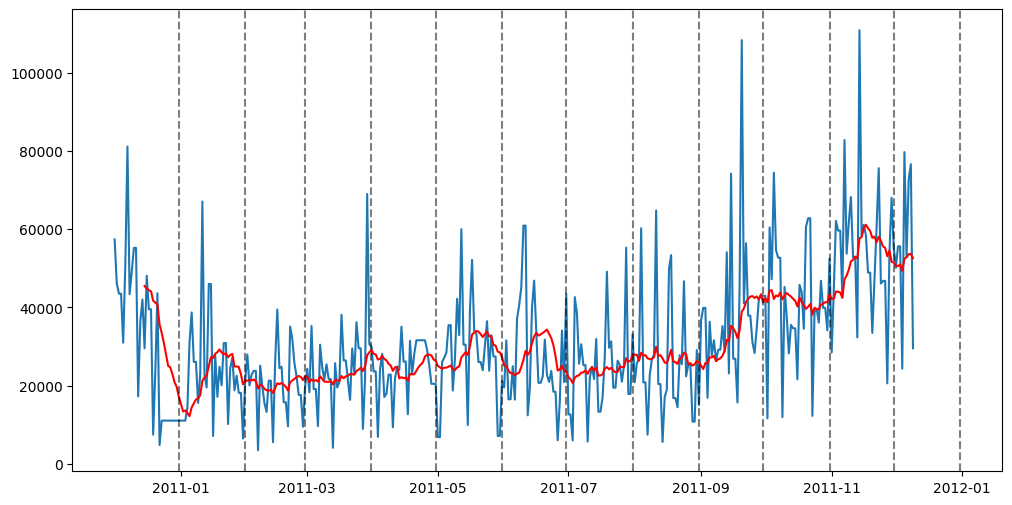

In [193]:
plt.figure(figsize=(12,6))
plt.plot(dailyrev.index, dailyrev)
revenue_smooth = dailyrev.rolling(window=15).mean()
plt.plot(revenue_smooth.index, revenue_smooth, color='red', label='7-Day Moving Avg')  # Smoothed

for month in real_stuff["InvoiceDate"].dt.to_period("M").unique():
    plt.axvline(month, color='k', linestyle='--', alpha=0.5)

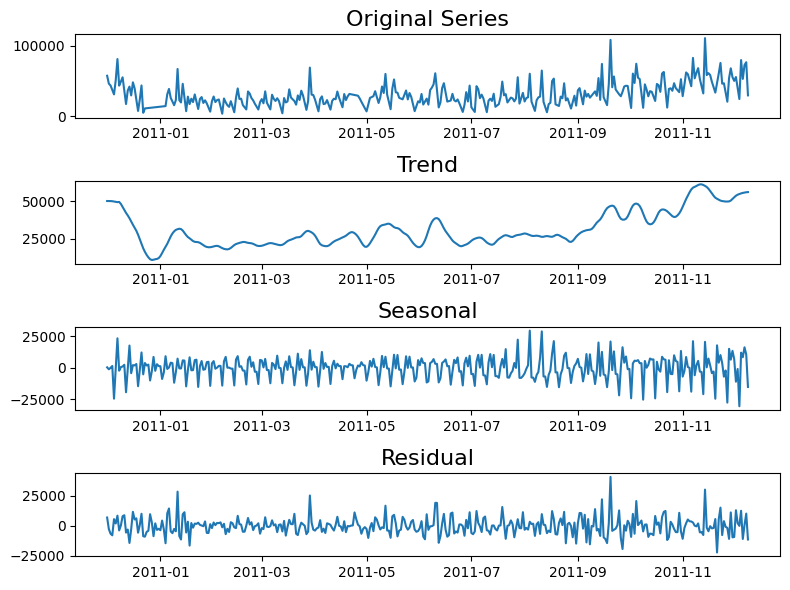

In [186]:
stl = STL(dailyrev)
result = stl.fit()

seasonal, trend, resid = result.seasonal, result.trend, result.resid
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(stuff)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

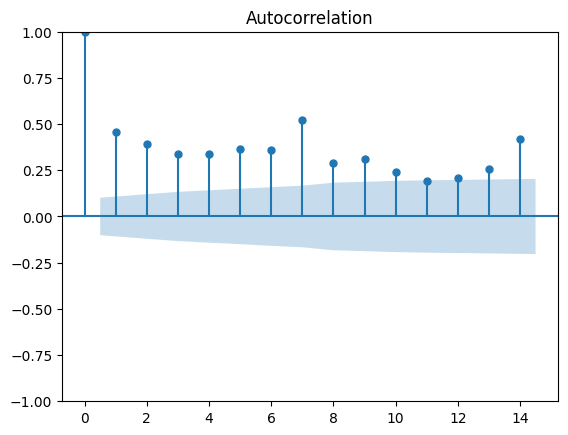

In [189]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF to identify seasonal period
plot_acf(dailyrev, lags=14)  # Check for peaks at lags 7, 14, 21, etc. (weekly seasonality)
plt.show()